## Final Project pt. 2

Import all modules. Numpy, astropy, sep and matplotlib.

Read data of the HUDF f105w fits file using astropy into a 2D numpy array, and reorder bytes to avoid error. Define mean and standard deviation of data, and show resulting image.

In [148]:
import numpy as np
import sep

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [149]:
image = get_pkg_data_filename("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

data = fits.getdata(image, ext=0)
data = data.byteswap(inplace=True).newbyteorder()

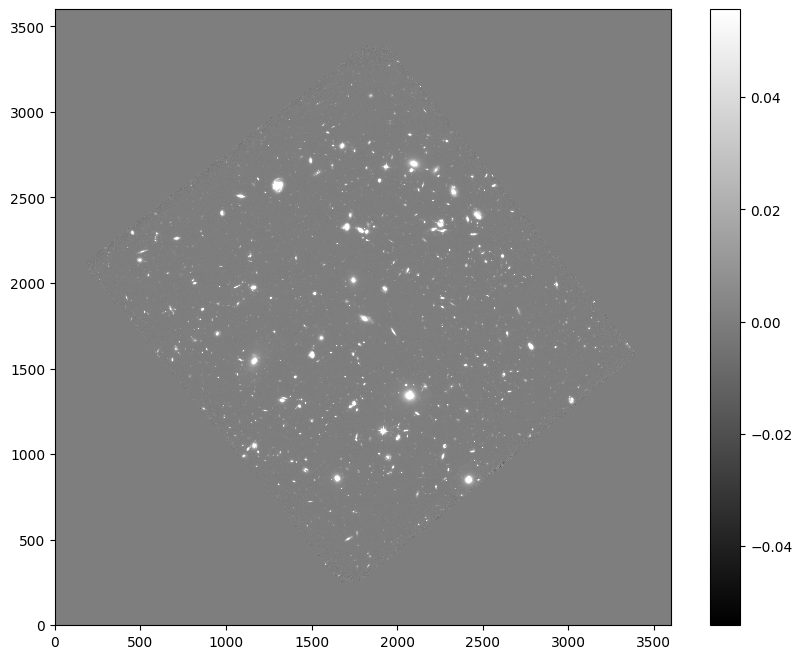

In [150]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

plt.savefig('HubbleUltraDeep_image.png')

Measure a spacially varying background of the image, and get "global" mean and noise of it. Show resulting image.

In [151]:
bg = sep.Background(data)

print(bg.globalback)
print(bg.globalrms)

0.0
0.0005398219218477607


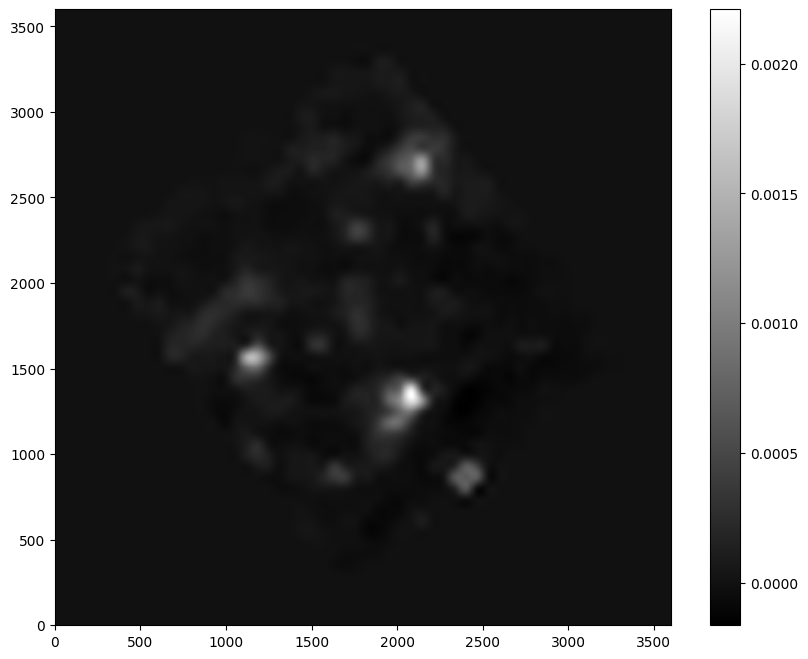

In [152]:
bg_image = bg.back()

plt.imshow(bg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('HubbleUltraDeep_bg.png')

Evaluate bg noise as 2D array. Show resulting image.

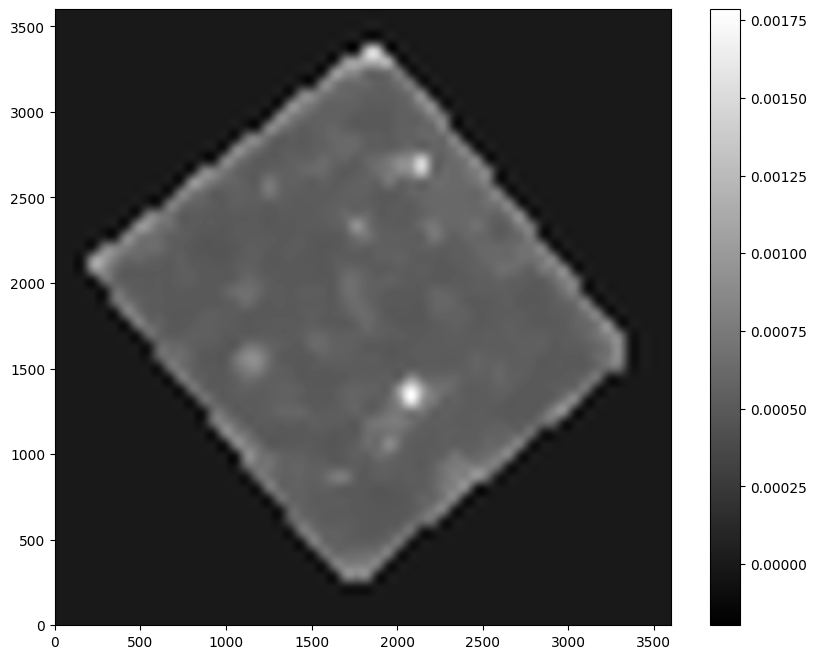

In [153]:
bg_rms = bg.rms()

plt.imshow(bg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('HubbleUltraDeep_bgNoise.png')

Subtract the calculated bg from the original data. Then run object detection on new data. Check how many objects were detected, and plot the new image with an ellipses for each detected object.

In [154]:
data_sub = data - bg

objects = sep.extract(data_sub, 1.5, err=bg.globalrms)
len(objects)

8638

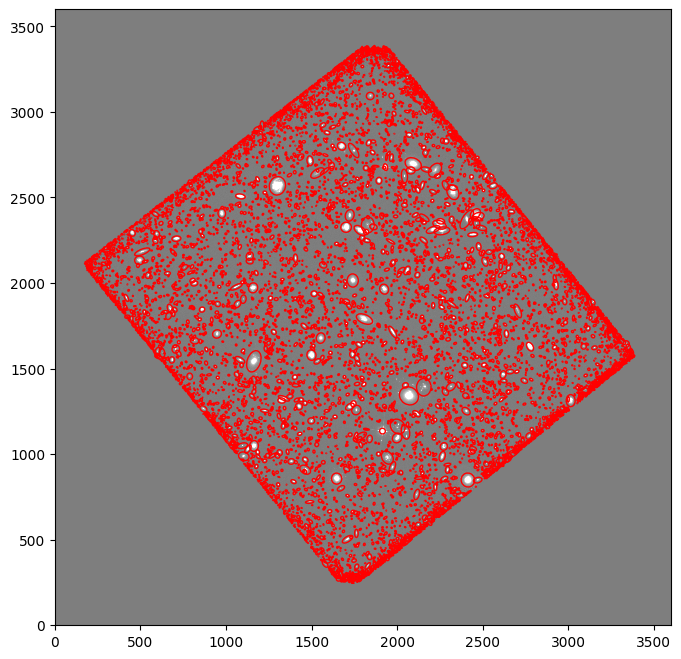

In [155]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('HubbleUltraDeep_Objects.png')

Perform circular aperture photometry with a 3 px radius at each object, to measure flux. Then, show the first 10 results.

Then, plot histogram of source fluxes.

In [156]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bg.globalrms, gain=1.0)

for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


8638 sources were found.
[ 0.03128197  0.03101789 -0.02438809 ...  0.08851303  0.01802793
  0.01398957]


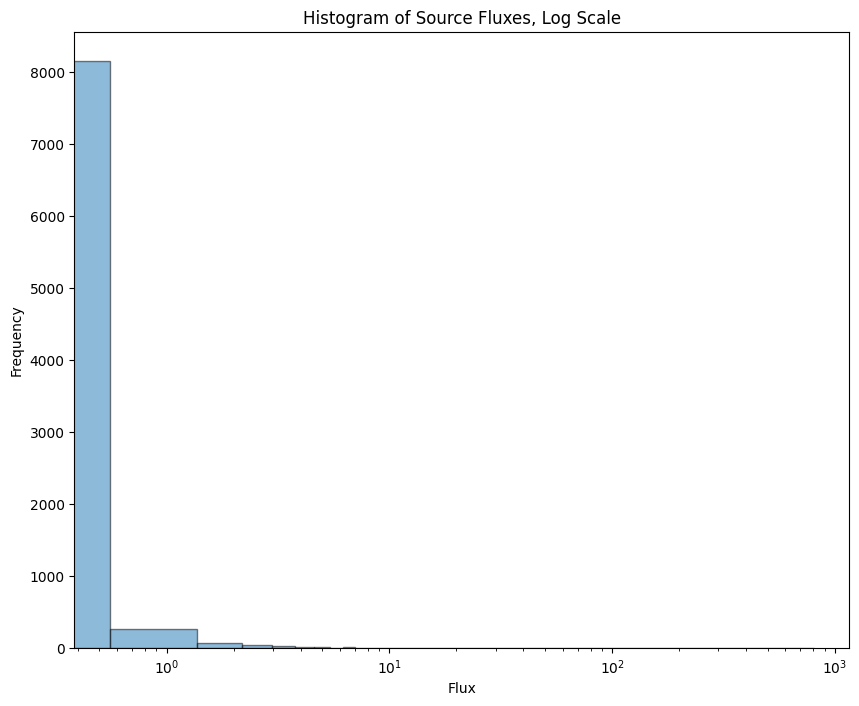

In [157]:
print(f"{len(objects)} sources were found.")

#plot the histogram, using logarithmic values on the x axis. Lots of bins to show all data
plt.hist(flux, bins=1000, alpha=0.5,edgecolor="black")
plt.xlabel('Flux')
plt.ylabel('Frequency')
plt.title("Histogram of Source Fluxes, Log Scale")
plt.xscale("log")

print(flux) #for me, to check values

Text(0.5, 1.0, 'Histogram of Source Fluxes, linear scale')

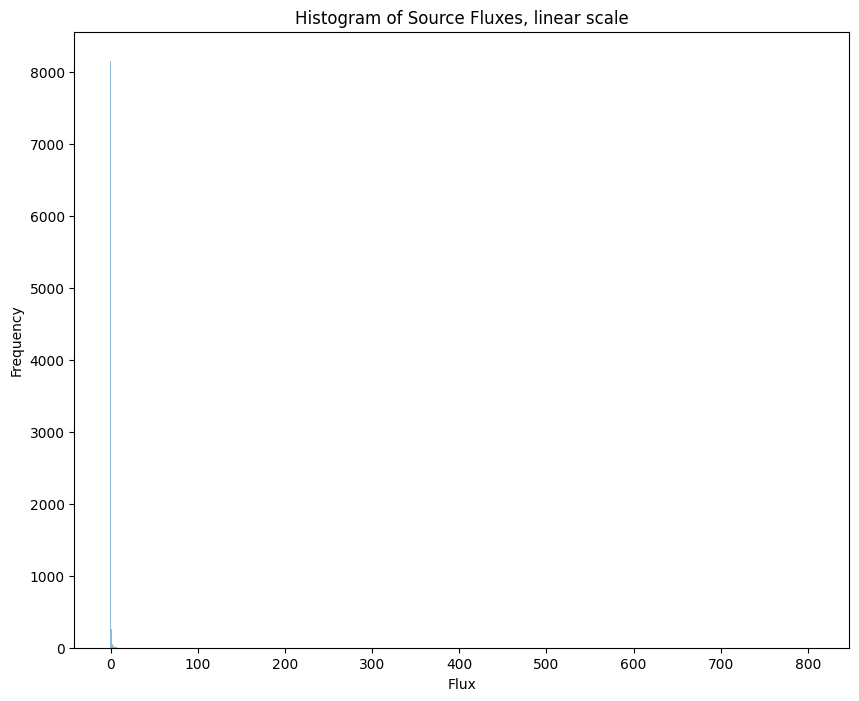

In [159]:
#plot the histogram, using linear values on the x axis. Lots of bins to show all data
plt.hist(flux, bins=1000, alpha=0.5)
plt.xlabel('Flux')
plt.ylabel('Frequency')
plt.title("Histogram of Source Fluxes, linear scale")

In [160]:
def outlier(data): #find outliers in flux(or other data set) within a threshold of 3 (standard outlier calculation)
    #credit to stack overflow, careerfoundry, geeksforgeeks, and askpython. research was done!
    outliers = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    #for each item in data set, calculate z_score using mean and std and test against threshold
    #if outside threshold, mark as an outlier!
    for y in data_1:
        z_score = (y - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
print(f"Outliers within the flux data set; {detect_outlier(flux)}")
print("\n")

#mean, median, and stdev of fluxes
mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)
#print these values
print(f"Mean of fluxes; {mean}")
print(f"Median of fluxes; {median}")
print(f"Standard Deviation of fluxes; {std}")
print("\n")

#calculate std from mean now that we know the value of the largest outlier
std_fromMean = np.abs(807.2972835731507-mean)/std
print(f"Largest outlier is {std_fromMean} standard deviations away from the mean.")

Outliers within the flux data set; [72.33984953880311, 65.90718430519105, 807.2972835731507, 52.12667887449266, 45.75134319305421, 77.9742225933075, 55.99823847532274, 35.85189163804054, 34.961994493007666, 30.024165342450143, 214.1414422988892, 43.59707835912704, 80.5576771605015]


Mean of fluxes; 0.3619352265305736
Median of fluxes; 0.030969079434980812
Standard Deviation of fluxes; 9.244596659828042


Largest outlier is 87.28724227127394 standard deviations away from the mean.


The largest outlier visible on the histogram is just under 10^1, but the range suggests it's somewhere near 10^3. Similarly, on the linear scale histogram, the largest visible value is near 30, but the range suggests an outlier larger than 800. 

From the function above, we can see that the largest outlier in this distribution is about 807. It is roughly 87 standard deviations away from the mean.

## Creating colorized image

Open and read all the fits files to get images!

In [161]:
#define file names
img_105 = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
img_125 = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
img_160 = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

#read data
hdu_2 = fits.open(img_105)
hdu_3 = fits.open(img_125)
hdu_4 = fits.open(img_160)

#get img data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

Make a function to rescale the image data, and apply it to our data. Compile rescaled data into one array. Used session 19!

In [162]:
def rescale_img(data):
    #copy data so it's not overwritten
    #compute the mean over all data while excluding errors
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)

    #check if lower than vpmin or higher than vmax, and apply them accordingly
    vpmin = 0.5*m
    vpmax = 100*m
    pdata_tmp[pdata_tmp<vpmin] = vpmin
    pdata_tmp[pdata_tmp>vpmax] = vpmax
    pdata_tmp = np.nan_to_num(pdata_tmp, nan=vpmin)

    #apply logarithmic scale and return
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp

#rescaling original images
data_2_res = rescale_img(data_2)
data_3_res = rescale_img(data_3)
data_4_res = rescale_img(data_4)

#compile all images into one data set array
data_all = np.zeros((data_2.shape[0],data_2.shape[1],3))
data_all[:,:,0] = data_2
data_all[:,:,1] = data_3
data_all[:,:,2] = data_4
data_all = rescale_img(data_all)

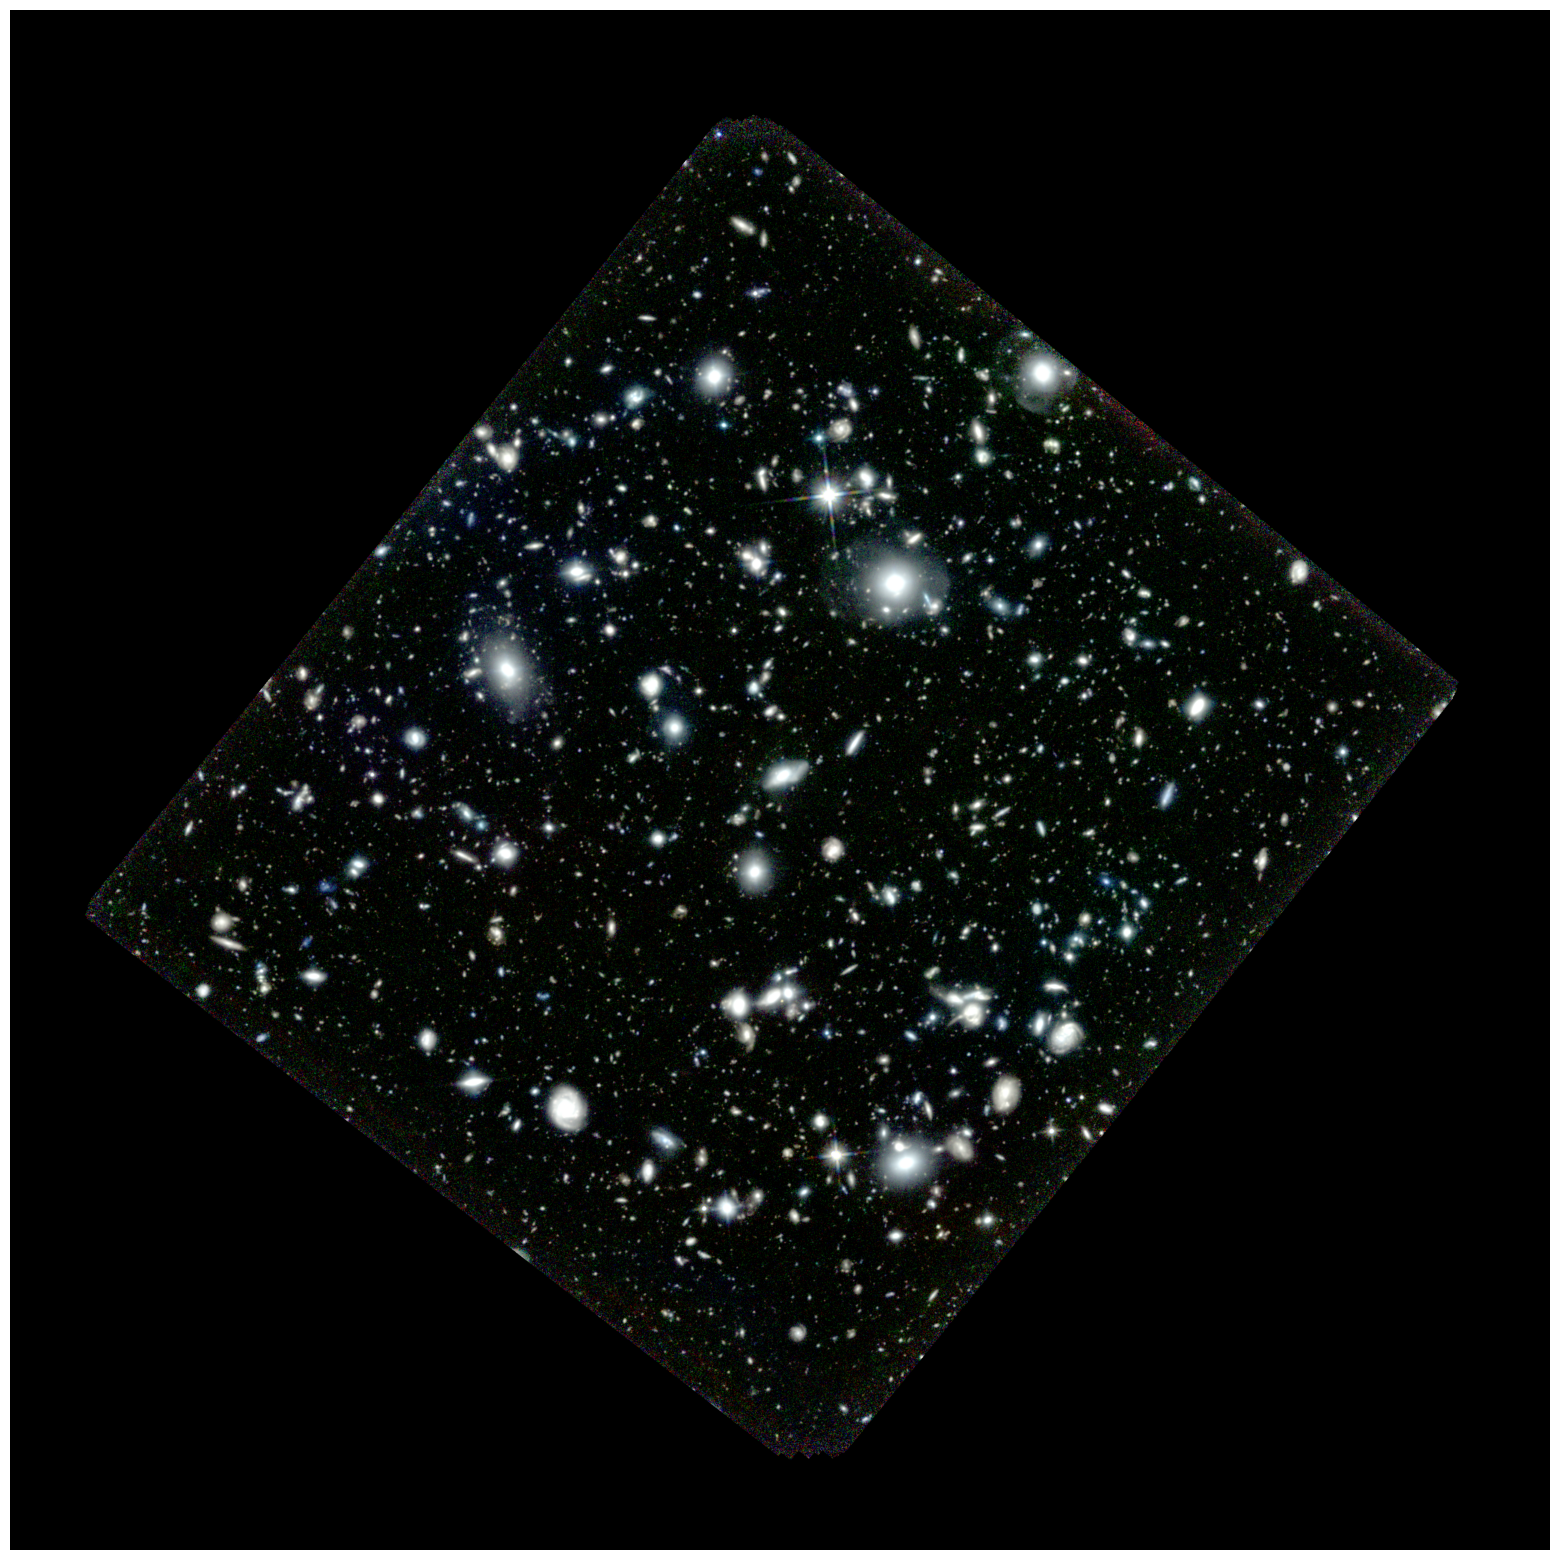

In [163]:
def remap(data): #map arrays to [0,1]
    pdata_tmp = data.copy()

    dmin = pdata_tmp.min()
    dmax = pdata_tmp.max()
    return (pdata_tmp - dmin)/(dmax - dmin)

#create RBG image with size of ny x ny x 3!
rbg_img = np.zeros((data_2.shape[0],data_2.shape[1],3))
rbg_img = remap(data_all)

#plot and save it
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis("off")
ax.imshow(rbg_img)
plt.savefig('3colorHUDFimage.png')